### Importanto bibliotecas

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import plotly.express as px
import time

from utils import *

### Classe da Empresa que ira calcular receita, vendas etc

In [3]:
class Empresa:
    def __init__(self, nome, receita, propaganda, num_vendedores, salario_vendedores, hora_extra, estocagem):
        self.nome = nome
        self.receita = receita
        self.propaganda = propaganda
        self.num_vendedores = num_vendedores
        self.salario_vendedores = salario_vendedores
        self.hora_extra = hora_extra
        self.estocagem = estocagem

    def calcular_despesas(self):
        salario_total = self.num_vendedores * self.salario_vendedores
        custo_hora_extra = self.hora_extra if self.hora_extra is not None else 0
        custo_estocagem = self.estocagem if self.estocagem is not None else 0

        despesas = {
            "Propaganda": self.propaganda,
            "Salário Vendedores": salario_total,
            "Hora Extra": custo_hora_extra,
            "Estocagem": custo_estocagem
        }

        return despesas

    def calcular_cmv(self):
        return 0.2 * self.receita

    def calcular_despesas_fixas(self):
        return {
            "Salários": 0.08 * self.receita,
            "Aluguel": 2000
        }

    def calcular_total_despesas(self):
        despesas = self.calcular_despesas()
        despesas_fixas = self.calcular_despesas_fixas()

        total_despesas = sum(despesas.values()) + sum(despesas_fixas.values())
        return total_despesas

    def calcular_resultado(self):
        return self.receita - self.calcular_cmv() - self.calcular_total_despesas()

    def esta_falida(self):
        return self.calcular_resultado() < 0
    
    def get_params(self):
        return {
            'nome': self.nome,
            'receita': self.receita,
            'propaganda': self.propaganda,
            'num_vendedores': self.num_vendedores,
            'salario_vendedores': self.salario_vendedores,
            'hora_extra': self.hora_extra,
            'estocagem': self.estocagem,
            'cmv': self.calcular_cmv(),
            'despesas': self.calcular_total_despesas(),
        }


### Classe Simulador de Empresas que ira simular com aleatorias ou usuarios

In [4]:
class SimuladorEmpresas:
    def __init__(self, num_empresas_users, num_empresas_aleatorias, bounds):
        self.empresas = []
        self.num_empresas_users = num_empresas_users
        self.num_empresas_aleatorias = num_empresas_aleatorias
        self.resultados = []  # Store results here
        if bounds is None:
            self.bounds = {
                'receita': (10000, 1000000),
                'propaganda': (100, 10000),
                'num_vendedores': (5, 100),
                'salario_vendedores': (1000, 2000),
                'hora_extra': (100, 1000),
                'estocagem': (50, 1000)
            }
        else:
            self.bounds = bounds

    def criar_empresas_aleatorias(self):
        for i in range(self.num_empresas_aleatorias):
            nome = f"Empresa Aleatória {i+1}"
            receita = random.uniform(*self.bounds['receita'])  # Random revenue
            propaganda = random.uniform(*self.bounds['propaganda'])  # Random advertising expenses
            num_vendedores = random.randint(*self.bounds['num_vendedores'])  # Random number of employees
            salario_vendedores = random.uniform(*self.bounds['salario_vendedores'])  # Random employee salaries
            hora_extra = random.uniform(*self.bounds['hora_extra'])  # Random overtime costs
            estocagem = random.uniform(*self.bounds['estocagem'])  # Random storage costs

            empresa = Empresa(nome, receita, propaganda, num_vendedores, salario_vendedores, hora_extra, estocagem)
            self.empresas.append(empresa)

    def inserir_dados_usuario(self):
        for i in range(self.num_empresas_users):
            print(f"\nInserir dados para a Empresa {i + 1}:")
            nome = input("Nome da Empresa: ")
            receita = self._get_input("Receita de vendas (faturamento): ", float, *self.bounds['receita'])
            propaganda = self._get_input("Despesa com propaganda: ", float, *self.bounds['propaganda'])
            num_vendedores = self._get_input("Número de vendedores: ", int, *self.bounds['num_vendedores'])
            salario_vendedores = self._get_input("Salário por vendedor: ", float, *self.bounds['salario_vendedores'])
            hora_extra = self._get_input("Custo de hora extra (ou Enter para 0): ", float, *self.bounds['hora_extra'])
            estocagem = self._get_input("Custo de estocagem (ou Enter para 0): ", float, *self.bounds['estocagem'])

            empresa = Empresa(nome, receita, propaganda, num_vendedores, salario_vendedores, hora_extra, estocagem)
            self.empresas.append(empresa)

    def _get_input(self, prompt, type_, min_, max_):
        while True:
            try:
                value = type_(input(prompt))
                if min_ <= value <= max_:
                    return value
                else:
                    print(f"Porfavor insira um valor entre {min_} e {max_}.")
            except ValueError:
                print("Input invalido. Porfavor tente novamente.")

    def calcular_e_exibir_resultados(self):
        self.resultados = []  # Reset the results
        for empresa in self.empresas:
            resultado = empresa.calcular_resultado()
            self.resultados.append(resultado)

        classificacao = sorted(enumerate(self.resultados, start=1), key=lambda x: x[1])
        classificacao_final = {empresa[0]: i for i, empresa in enumerate(classificacao, start=1)}

        print("\nDemonstrativo de Resultados")
        print("Empresa\tResultado\tClassificação\tStatus")
        for i, (empresa, resultado) in enumerate(zip(self.empresas, self.resultados), start=1):
            status = "Falida" if empresa.esta_falida() else "Ativa"
            print(f"{empresa.nome}\t{resultado:.2f}\t\t{classificacao_final[i]}\t\t{status}")

    def plotar_grafico_lucro(self):
        data = {
            "Empresa": [empresa.nome for empresa in self.empresas],
            "Resultado": self.resultados,  # Use the stored results
            "Status": ["Falida" if empresa.esta_falida() else "Ativa" for empresa in self.empresas]
        }
        df = pd.DataFrame(data)

        plt.figure(figsize=(10, 6))
        sns.barplot(x="Empresa", y="Resultado", hue="Status", data=df)
        plt.title("Resultados das Empresas")
        plt.xlabel("Empresa")
        plt.ylabel("Resultado")
        plt.show()

    def plotar_grafico_relatorio_geral(self):
        data = {
            "Empresa": [empresa.nome for empresa in self.empresas],
            "Propaganda": [empresa.propaganda for empresa in self.empresas],
            "Receita": [empresa.receita for empresa in self.empresas],
            "Salário Vendedores": [empresa.salario_vendedores for empresa in self.empresas],
            "Hora Extra": [empresa.hora_extra for empresa in self.empresas],
            "Estocagem": [empresa.estocagem for empresa in self.empresas],
            "CMV": [empresa.calcular_cmv() for empresa in self.empresas],
            "Despesas": [empresa.calcular_total_despesas() for empresa in self.empresas],
            "Resultado": [empresa.calcular_resultado() for empresa in self.empresas]
        }
        df = pd.DataFrame(data)

        df_percentage = transform_df_percentage(df)
        

        # Melt the DataFrame
        df_melt = pd.melt(df_percentage, id_vars="Empresa", var_name="variable", value_name="value")

        # Create the bar plot
        fig = px.bar(df_melt, x="Empresa", y="value", color="variable", barmode="group",
                    title="Relatório Geral das Empresas", labels={"value": "Percentual do Total (%)", "variable": "Variáveis"})

        # Show the plot
        fig.show()
        
    def salvar_resultados(self):
        data = {
            "Empresa": [empresa.nome for empresa in self.empresas],
            "Propaganda": [empresa.propaganda for empresa in self.empresas],
            "Receita": [empresa.receita for empresa in self.empresas],
            "Salário Vendedores": [empresa.salario_vendedores for empresa in self.empresas],
            "Hora Extra": [empresa.hora_extra for empresa in self.empresas],
            "Estocagem": [empresa.estocagem for empresa in self.empresas],
            "CMV": [empresa.calcular_cmv() for empresa in self.empresas],
            "Despesas": [empresa.calcular_total_despesas() for empresa in self.empresas],
            "Resultado": self.resultados
        }
        df = pd.DataFrame(data)
        return df
    

    def proximo_round(self):
        empresas_ativas = [empresa for empresa in self.empresas if not empresa.esta_falida()]
        empresas_falidas = [empresa for empresa in self.empresas if empresa.esta_falida()]
        if len(empresas_ativas) == 1:
            print(f"Empresa vencedora: {empresas_ativas[0].nome}")
        elif empresas_falidas:
            self.empresas = empresas_ativas
            print("As seguintes empresas foram removidas por falência:")
            for empresa in empresas_falidas:
                print(f"- {empresa.nome}")
        else:
            min_lucro = min(self.resultados)
            empresa_menor_lucro = self.empresas[self.resultados.index(min_lucro)]
            self.empresas.remove(empresa_menor_lucro)
            print(f"A empresa {empresa_menor_lucro.nome} foi removida por ter o menor lucro.")


Inserir dados para a Empresa 1:
Input invalido. Porfavor tente novamente.
Input invalido. Porfavor tente novamente.
Input invalido. Porfavor tente novamente.
Input invalido. Porfavor tente novamente.
Input invalido. Porfavor tente novamente.
Input invalido. Porfavor tente novamente.
Input invalido. Porfavor tente novamente.
Porfavor insira um valor entre 10000 e 1000000.

Demonstrativo de Resultados
Empresa	Resultado	Classificação	Status
Empresa Aleatória 1	488629.19		5		Ativa
Empresa Aleatória 2	-8741.55		2		Falida
Empresa Aleatória 3	7865.99		3		Ativa
Empresa Aleatória 4	541613.92		6		Ativa
Empresa Aleatória 5	107883.56		4		Ativa
	-96900.00		1		Falida


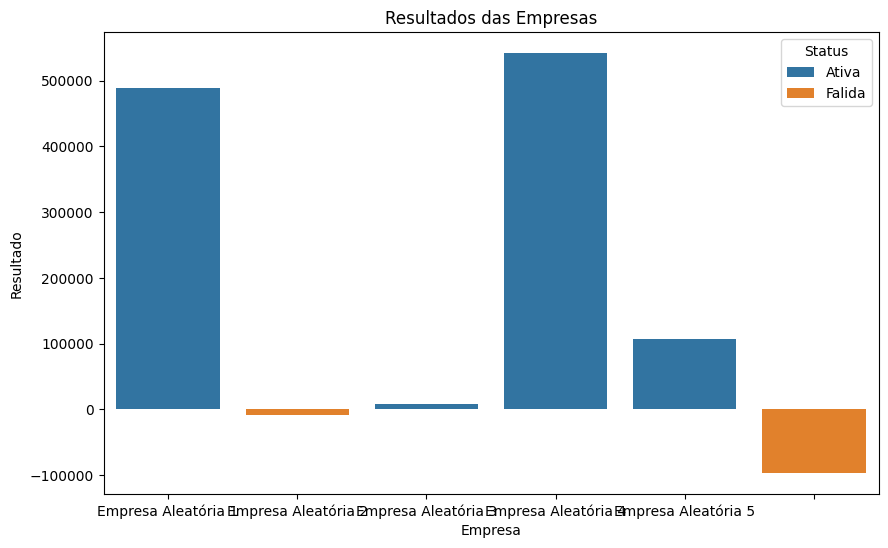

In [5]:
if __name__ == "__main__":
    num_empresas_ale = 5  # Set the number of companies you want to simulate
    num_empresas_users = 1  # Set the number of companies you want to enter data for
    simulador = SimuladorEmpresas(num_empresas_users=num_empresas_users, num_empresas_aleatorias=num_empresas_ale, bounds=None)
simulador.criar_empresas_aleatorias()
simulador.inserir_dados_usuario()
simulador.calcular_e_exibir_resultados()
simulador.plotar_grafico_lucro()
simulador.plotar_grafico_relatorio_geral()

### With Rounds


Round 1

Demonstrativo de Resultados
Empresa	Resultado	Classificação	Status
Empresa Aleatória 1	150749.96		2		Ativa
Empresa Aleatória 2	62391.85		1		Ativa
Empresa Aleatória 3	612100.03		5		Ativa
Empresa Aleatória 4	307905.11		4		Ativa
Empresa Aleatória 5	266798.36		3		Ativa
Keiko Corp.	697750.00		6		Ativa


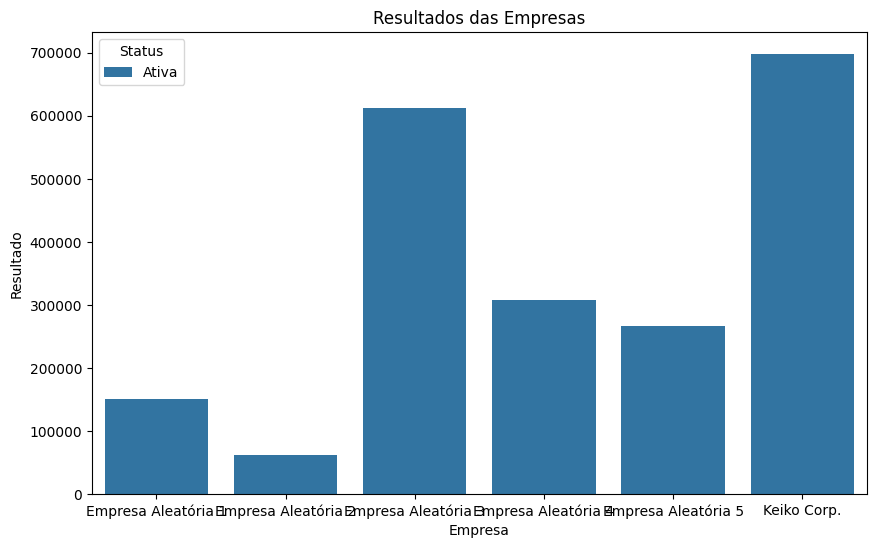

A empresa Empresa Aleatória 2 foi removida por ter o menor lucro.

Round 2

Demonstrativo de Resultados
Empresa	Resultado	Classificação	Status
Empresa Aleatória 1	150749.96		1		Ativa
Empresa Aleatória 3	612100.03		4		Ativa
Empresa Aleatória 4	307905.11		3		Ativa
Empresa Aleatória 5	266798.36		2		Ativa
Keiko Corp.	697750.00		5		Ativa


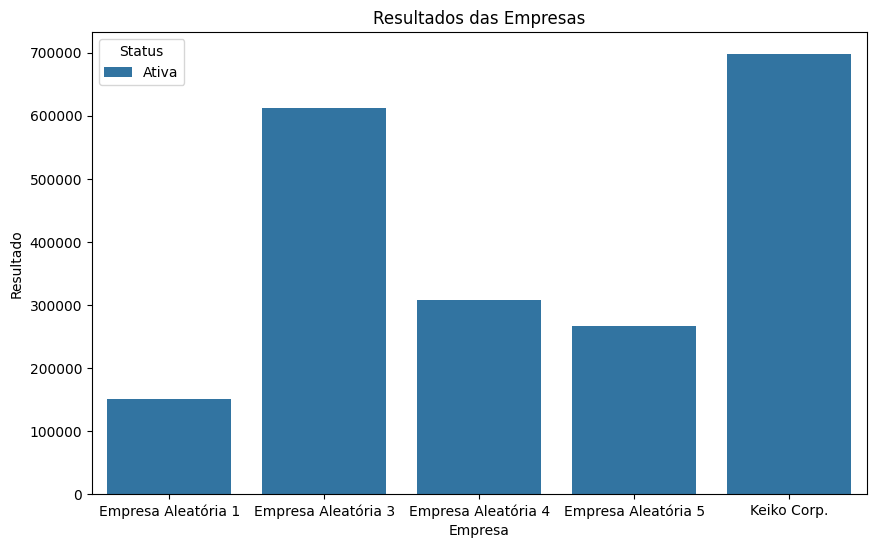

A empresa Empresa Aleatória 1 foi removida por ter o menor lucro.

Round 3

Demonstrativo de Resultados
Empresa	Resultado	Classificação	Status
Empresa Aleatória 3	612100.03		3		Ativa
Empresa Aleatória 4	307905.11		2		Ativa
Empresa Aleatória 5	266798.36		1		Ativa
Keiko Corp.	697750.00		4		Ativa


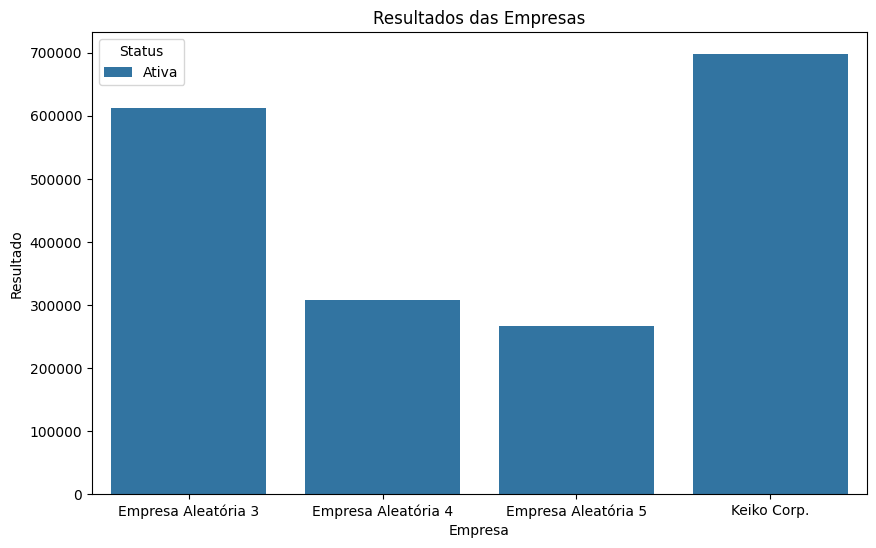

A empresa Empresa Aleatória 5 foi removida por ter o menor lucro.

Round 4

Demonstrativo de Resultados
Empresa	Resultado	Classificação	Status
Empresa Aleatória 3	612100.03		2		Ativa
Empresa Aleatória 4	307905.11		1		Ativa
Keiko Corp.	697750.00		3		Ativa


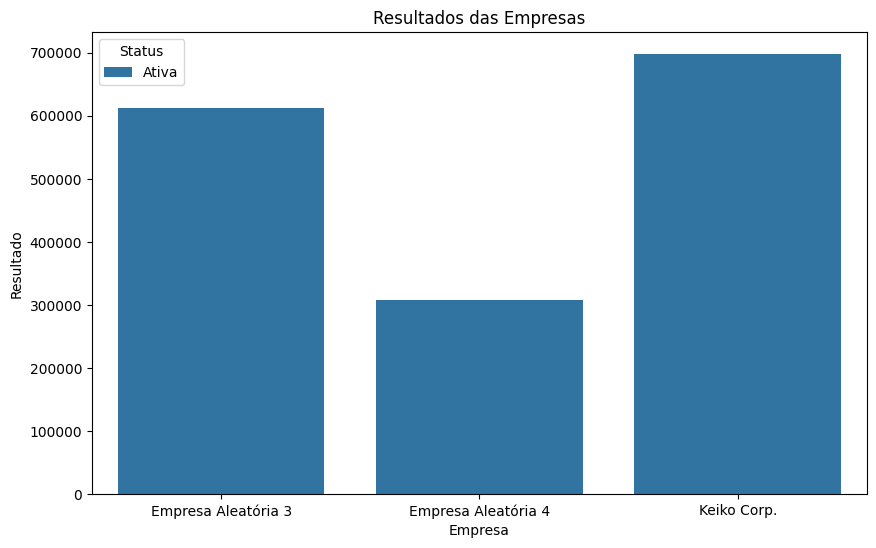

A empresa Empresa Aleatória 4 foi removida por ter o menor lucro.

Round 5

Demonstrativo de Resultados
Empresa	Resultado	Classificação	Status
Empresa Aleatória 3	612100.03		1		Ativa
Keiko Corp.	697750.00		2		Ativa


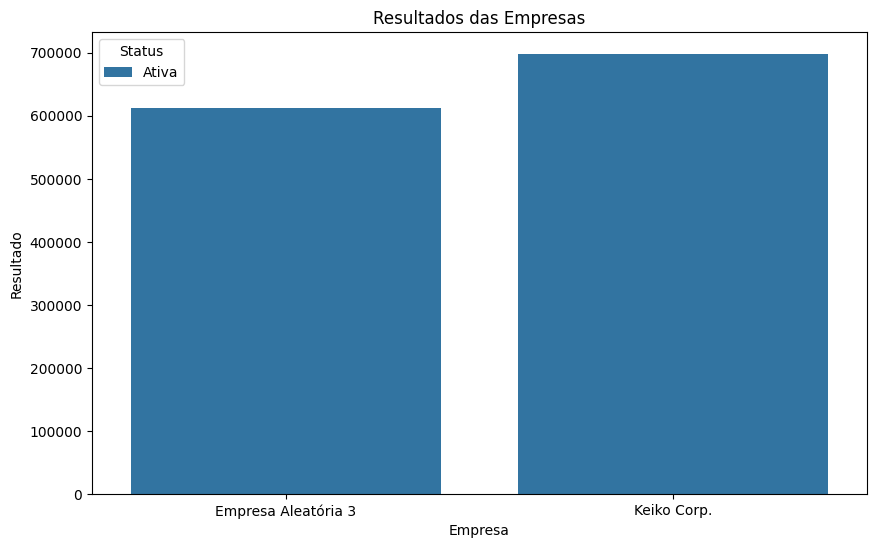

A empresa Empresa Aleatória 3 foi removida por ter o menor lucro.


In [6]:
for i in range(5):
    print(f"\nRound {i + 1}")
    # se existe só uma empresa, não precisa rodar o simulador
    if len(simulador.empresas) == 1:
        simulador.proximo_round()
        break
    
    simulador.calcular_e_exibir_resultados()

    # se existe mais de uma empresa, plota os gráficos
    if len(simulador.empresas) > 1:
        simulador.plotar_grafico_lucro()
        simulador.plotar_grafico_relatorio_geral()

    # mostra os resultados do round
    simulador.proximo_round()
    time.sleep(3)
